In [18]:
### Library Imports
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### Notes
# In a pairs trading strategy, the positions (long and short) should ideally be taken at the beginning 
# when a trading signal is generated and should remain constant until an exit signal is triggered. The 
# position sizes should not change over time.

### Resources
# https://www.cmcmarkets.com/en/trading-guides/pairs-trading -> Overview of Pairs Trading
# https://hudsonthames.org/an-introduction-to-cointegration/ -> Cointegration for Pairs Trading
# https://github.com/KidQuant/Pairs-Trading-With-Python/blob/master/PairsTrading.ipynb -> Full Project


In [19]:
### Function to Get Commodities Data
def import_commod_data(tickers, start_date, end_date):
    data = pd.DataFrame()
    for t in tickers:
        data[t] = yf.download(t, start = start_date, end = end_date)['Adj Close']
    data = data.replace([np.inf, -np.inf], np.nan).dropna() # Drop nan and inf values
    return data

### Function Call to Load Commodities Data for the Date Range
# Choose Commodities Pair
commodities = ['BZ=F', 'LE=F'] #['PL=F', 'PA=F']
start_date = '2023-07-01'
end_date = '2024-07-01'
# Download data
data = import_commod_data(commodities, start_date, end_date)
print(data.tail())


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

                 BZ=F        LE=F
Date                             
2024-06-24  86.010002  188.899994
2024-06-25  85.010002  189.475006
2024-06-26  85.250000  192.925003
2024-06-27  86.389999  194.175003
2024-06-28  86.410004  193.500000


In [20]:
### Function to Compute Spread and Z-Score
def spread_and_zscore(series1, series2):
    # Calculate the spread between two series
    spread = series1 - series2 
    # Calculate the Z-score of the spread
    z_score = (spread - spread.mean()) / spread.std()  
    return spread, z_score

### Function Call to Compute Spread and Z-Score
# Define Metals
metal1_data = data[commodities[0]]
metal2_data = data[commodities[1]]
#print(metal1_data)
spread, z_score = spread_and_zscore(metal1_data, metal2_data)
print('Most recent computed spread is: ', round(spread.iloc[-1], 4))
print('Most recent computed z-score is: ', round(z_score.iloc[-1], 4))


Most recent computed spread is:  -107.09
Most recent computed z-score is:  -2.316


In [21]:
### Function to check for cointegration
# The cointegration test checks whether there is a long-term equilibrium relationship between the two time series
def check_cointegration(series1, series2):
    # Perform the cointegration test from .coint() function
    result = sm.tsa.stattools.coint(series1, series2)  
    # Extract the p-value from the cointegration test results
    p_val = result[1]  
    return p_val

### Function Call to Compute P Value
# If the p-value is less than a significance level (commonly 0.05), the null hypothesis of no cointegration is rejected, 
# indicating that the series are cointegrated
p_value = check_cointegration(metal1_data, metal2_data)

if p_value > 0.05:
    print(
        'The computed p-value is:', round(p_value, 4), 
        'and thus the null hypothesis of no cointegration cannot be rejected, \n'
        'so the assumption of mean reversion may not hold and these pairs should NOT be considered'
    )
elif p_value < 0.05:
    print(
        'The computed p-value is:', round(p_value, 4), 
        'and thus the null hypothesis of no cointegration is rejected, \n'
        'so the assumption of mean reversion holds and these pairs should be considered'
    )


The computed p-value is: 0.0443 and thus the null hypothesis of no cointegration is rejected, 
so the assumption of mean reversion holds and these pairs should be considered


In [22]:
### Calculate Trend Signals Based on Z-Score
''' 
The z-score is used to generate trading signals based on predefined thresholds:
  - When the z-score is below -1, it indicates that the spread is significantly below its mean (i.e., one asset 
    is undervalued compared to the other). 
    This means commodity 1 (series1) is cheaper than normal and commodity 2 (series2) is more expensive than normal
    Hence, the strategy goes long on commodity 1 (buying 1000 units) and short on commodity 2 (selling 1000 units)

  - When the z-score is above 1, it indicates that the spread is significantly above its mean (i.e., one asset 
    is overvalued compared to the other). 
    This means commodity 1 (series1) is more expensive than normal and commodity 2 (series2) is cheaper than normal
    Hence, the strategy goes short on commodity 1 (selling 1000 units) and long on commodity 2 (buying 1000 units)
    
  - Positions are exited when the z-score reverts to a value between -0.5 and 0.5, indicating that the spread 
    has reverted to its mean.
'''
# Function to Generate Trading Signals
def generate_signals(data, commodities):
    series1 = data[commodities[0]]
    series2 = data[commodities[1]]
    
    spread, z_score = spread_and_zscore(series1, series2)  # Compute spread and Z-score
    
    # Generate trading signals based on Z-score thresholds
    longs = z_score < -1  # Long signal when Z-score is less than -1
    shorts = z_score > 1  # Short signal when Z-score is greater than 1
    exits = abs(z_score) < 0.5  # Exit signal when Z-score is between -0.5 and 0.5
    
    signals = pd.DataFrame(index=data.index)
    signals['longs'] = longs
    signals['shorts'] = shorts
    signals['exits'] = exits
    
    return signals, spread, z_score

### Function Call to Generate Trading Signals
signals, spread, z_score = generate_signals(data, commodities)
print("Signals Head:\n", signals.head())
print("Spread and Z-Score Head:\n", spread.head(), z_score.head())


Signals Head:
             longs  shorts  exits
Date                            
2023-07-03   True   False  False
2023-07-05  False   False   True
2023-07-06  False   False   True
2023-07-07  False   False  False
2023-07-10  False   False  False
Spread and Z-Score Head:
 Date
2023-07-03   -102.174995
2023-07-05    -98.299995
2023-07-06    -98.055000
2023-07-07    -98.529999
2023-07-10    -99.509995
dtype: float64 Date
2023-07-03   -1.273441
2023-07-05   -0.451448
2023-07-06   -0.399478
2023-07-07   -0.500238
2023-07-10   -0.708122
dtype: float64


In [26]:
### Function to Calculate the position
def backtest(signals, data, commodities):
    # Initialize positions df
    positions = pd.DataFrame(index = signals.index)
    # Initialize positions for the first commodity
    positions[commodities[0]] = 0  
    positions[commodities[1]] = 0  

    for i in range(len(signals)):
        if signals['longs'].iloc[i]:  # Long signal
            total_value = 1000  # Total value to be invested in each position
            ''' 
            total_value / data[commodities[0]].iloc[i]
            This calculates the number of units (shares or contracts) to be held for the first commodity (commodities[0]). 
            It divides the total value (1000) by the price of the first commodity on day i to determine how many units 
            can be purchased with 1000 units of capital

            -total_value / data[commodities[1]].iloc[i]
            This part calculates the number of units to be held for the second commodity (commodities[1]). It divides the 
            total value (1000) by the price of the second commodity on day i to determine how many units can be shorted 
            with 1000 units of capital (hence the negative sign)

            For example, if the price of 'PL=F' is 10 and the price of 'PA=F' is 20 on day i, the positions would be:
            positions.iloc[i] = [1000 / 10, -1000 / 20], which means:
                Long 100 units of 'PL=F' (1000 / 10)
                Short 50 units of 'PA=F' (1000 / 20)
            This calculation ensures that a fixed total amount of capital is allocated to each long and short position, 
            regardless of the price of the commodities. This way, the strategy maintains a balanced exposure to both positions, 
            with equal total capital allocated to the long and short sides
            '''
            positions.iloc[i] = [total_value / data[commodities[0]].iloc[i], -total_value / data[commodities[1]].iloc[i]]
        elif signals['shorts'].iloc[i]:  # Short signal
            total_value = 1000  # Total value to be invested in each position
            positions.iloc[i] = [-total_value / data[commodities[0]].iloc[i], total_value / data[commodities[1]].iloc[i]]
        elif signals['exits'].iloc[i]:  # Exit signal
            positions.iloc[i] = [0, 0]  # Set positions to zero on exit
    
    # Calculate daily returns of the assets
    daily_rets = data.pct_change().dropna()
    # Calculate portfolio returns based on positions and daily returns
    returns = (positions.shift(1) * daily_rets).sum(axis=1)
    # Calculate cumulative returns over the period
    cumulative_rets = (returns + 1).cumprod() - 1

    return positions, returns, cumulative_rets

### Positions Function Call
positions, returns, cumulative_rets = backtest(signals, data, commodities)
print("Positions Tail:\n", positions.tail())
print("Daily Returns Tail:\n", returns.tail())
print("Cumulative Returns Tail:\n", cumulative_rets.tail())


Positions Tail:
                  BZ=F      LE=F
Date                           
2024-06-24  11.626555 -5.293806
2024-06-25  11.763322 -5.277741
2024-06-26  11.730205 -5.183361
2024-06-27  11.575414 -5.149993
2024-06-28  11.572734 -5.167959
Daily Returns Tail:
 Date
2024-06-24    0.069038
2024-06-25   -0.151291
2024-06-26   -0.062888
2024-06-27    0.123277
2024-06-28    0.020583
dtype: float64
Cumulative Returns Tail:
 Date
2024-06-24    107.847091
2024-06-25     91.379491
2024-06-26     85.569908
2024-06-27     96.242010
2024-06-28     98.243552
dtype: float64


In [24]:
### Function to Compute Performance Metrics
def calculate_performance_metrics(cumulative_rets, returns):
    # Calculate total return over the period (final value of cumulative returns)
    total_return = cumulative_rets.iloc[-1]
    
    # Calculate total amount return (based on 2000 total invested: 1000 long and 1000 short units)
    total_amount_return = total_return * 2000  # Total return in currency units
    
    # Calculate total percentage return over the period
    percentage_return = total_return * 100
    
    # Calculate the annualized return
    annualized_return = ((1 + total_return) ** (252 / len(cumulative_rets)) - 1) * 100
    
    # Calculate the Sharpe ratio
    sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252)
    
    return total_amount_return, percentage_return, annualized_return, sharpe_ratio

### Call Performance Function and Print Results
total_amount_return, percentage_return, annualized_return, sharpe_ratio = calculate_performance_metrics(cumulative_rets, returns)
print('Total amount invested: 2000 currency units (1000 long, 1000 short)')
print(f"Total Return: {total_amount_return:.2f} currency units")
print(f"Percentage Return: {percentage_return:.2f}%")
print(f"Annualized Return: {annualized_return:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")



Total amount invested: 2000 currency units (1000 long, 1000 short)
Total Return: 196487.10 currency units
Percentage Return: 9824.36%
Annualized Return: 10196.18%
Sharpe Ratio: 3.38


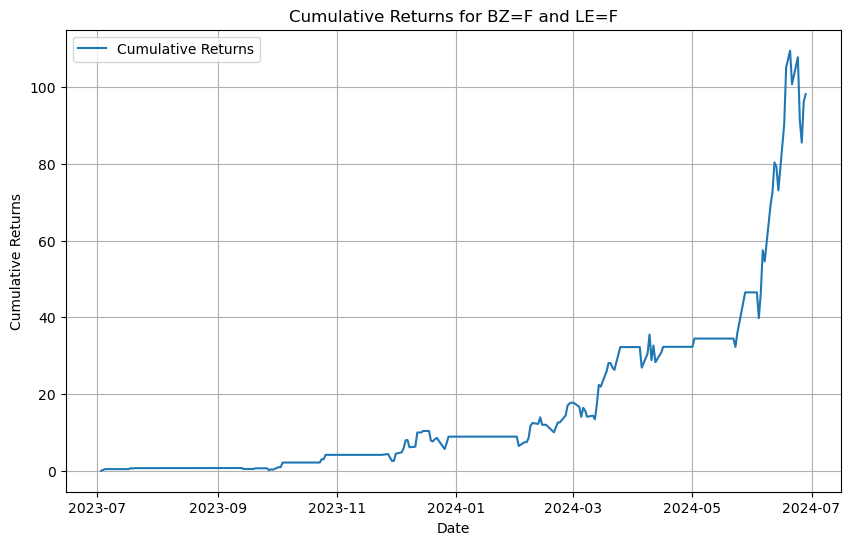

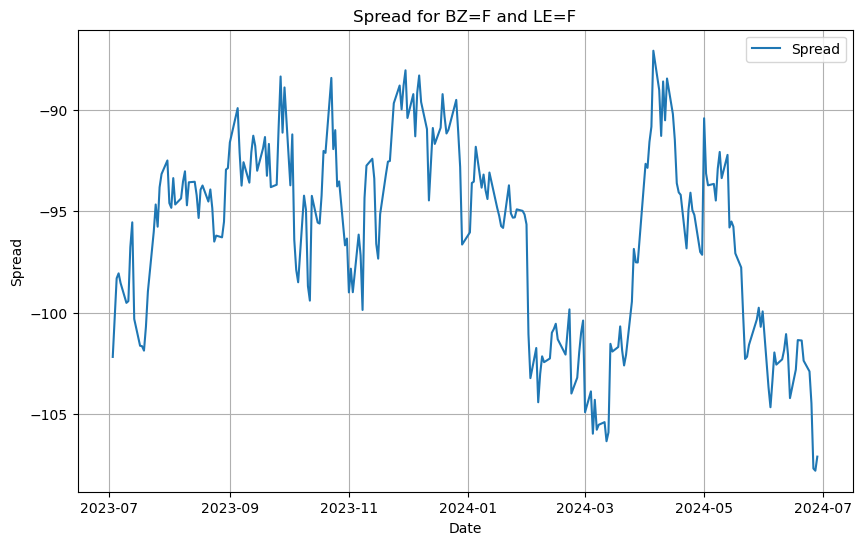

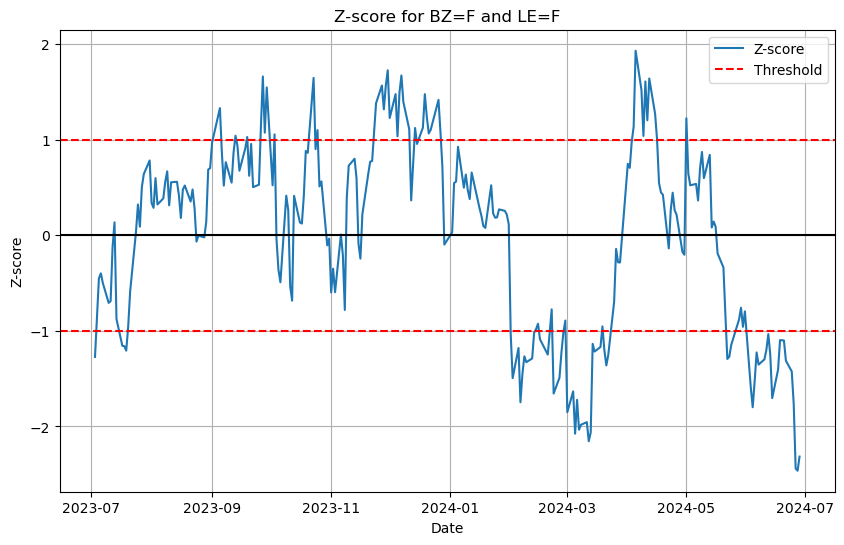

In [25]:
### Plot cumulative returns
def plots(spread, cumulative_rets, z_score, commodities):
    pair_name = f"{commodities[0]} and {commodities[1]}"

    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_rets, label='Cumulative Returns')
    plt.title(f'Cumulative Returns for {pair_name}')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)

    # Plot spread
    plt.figure(figsize=(10, 6))
    plt.plot(spread, label='Spread')
    plt.title(f'Spread for {pair_name}')
    plt.xlabel('Date')
    plt.ylabel('Spread')
    plt.legend()
    plt.grid(True)

    # Plot Z-score
    plt.figure(figsize=(10, 6))
    plt.plot(z_score, label='Z-score')
    plt.title(f'Z-score for {pair_name}')
    plt.xlabel('Date')
    plt.ylabel('Z-score')
    plt.axhline(1.0, color='r', linestyle='--', label='Threshold')
    plt.axhline(-1.0, color='r', linestyle='--')
    plt.axhline(0.0, color='k', linestyle='-')
    plt.legend()
    plt.grid(True)
    
    return plt.show()

# Example usage
commodities = ['BZ=F', 'LE=F']
plots(spread, cumulative_rets, z_score, commodities)
